# Getting POI Data

In [1]:
#Importing the importand libraries
import pandas as pd
import geopandas as gp
# OSMNX for getting OpenStreetMap Data
import osmnx as ox
# Folium for plotting maps
import folium

In [152]:
# Import POIs with an amenity tag
# https://wiki.openstreetmap.org/wiki/Key:amenity
tags = {'amenity': True}
poi = ox.geometries_from_place(query = {'city': 'Chicago'}, tags=tags)

# As we will see later not all public transport stops are marked with an amenity tag
# Therefore we will load a second datasetfor public transport related POIs
# https://wiki.openstreetmap.org/wiki/Key:public_transport
tags = {'public_transport': True}
transport = ox.geometries_from_place(query = {'city': 'Chicago'}, tags=tags)

### Amenity Data

In [192]:
# As we loaded the public transport data as a second dataframe we now exclude the double entries
poi = poi[poi["public_transport"].isna()]

In [193]:
# Reduce dataframe to important columns
poiDF = poi[["amenity", "geometry", "name"]].reset_index().set_index("osmid").drop("element_type", axis = 1).copy()
poiDF.tail(3)

,amenity,geometry,name
osmid,,,
15634307,university,"MULTIPOLYGON (((-87.62123 41.87938, -87.62192 ...",NaN
15652551,university,"MULTIPOLYGON (((-87.67137 41.87284, -87.67074 ...",Rush University
15809909,parking,"POLYGON ((-87.62236 41.89862, -87.62236 41.898...",NaN


In [194]:
# Have a look at the different types of POI and their occurrence
print(poiDF.groupby("amenity").count()["geometry"].sort_values(ascending=False).to_string())

amenity
parking                    6487
restaurant                 2193
place_of_worship           1880
fast_food                  1258
school                     1252
bar                         853
bicycle_rental              815
bicycle_parking             763
cafe                        739
bench                       665
bank                        443
fuel                        418
post_box                    224
toilets                     220
parking_entrance            211
fountain                    209
social_facility             191
shelter                     182
pharmacy                    181
drinking_water              177
clinic                      138
waste_basket                116
library                     109
fire_station                103
pub                         100
ice_cream                   100
post_office                  99
atm                          95
vending_machine              92
loading_dock                 89
theatre                      85


In [213]:
# For later analyses it could be interesting to group some tags and make a simpler categorization
# We don't group some items like for example transport related tags as their differences could be of importance
# Parking & Transport related POIs
car_parking = ["parking", "parking_entrance", 'parking_space']
bicycle_parking = ["bicycle_parking"]
bicycle_rental = ["bicycle_rental"]
bicycle_repair_station  =  ['bicycle_repair_station']
taxi = ['taxi']
car_sharing = ['car_sharing']
car_rental = ['car_rental']
water_transport = ["water_transport",'loading_dock', 'boat_rental','boat_storage']
fuel = ["fuel"]
# Other maybe important POIs
gastronomy = ["gastronomy", 'fast_food', 'cafe', 'restaurant', 'pub', 'bar', 'ice_cream', 'food_court', 'fast_food;ice_cream', 'biergarten']
place_of_worship = ['place_of_worship']
finance = ["finance", 'bank', 'atm', 'bureau_de_change', 'money_transfer', 'payment_terminal', 'payment_centre']
sports = ["sports", 'pilates', 'training']
health = ["health", 'pharmacy', 'hospital', 'dentist', 'clinic', 'nursing_home', 'doctors']
education = ["education", "music_school", 'school', 'university', 'college', 'language_school', 'library', 'prep_school', 'flight_school','research_institute']
nightlife = ["nightlife", 'stripclub', 'nightclub']
culture = ["culture", 'theatre', 'cinema', 'events_venue', 'planetarium', 'music_venue', 'arts_centre', 'exhibition_centre']
children = ["children", 'childcare', "kindergarten"]
police = ["police"]

category_list = [
car_parking,
bicycle_parking,
bicycle_rental,
bicycle_repair_station,
taxi,
car_sharing,
car_rental,
water_transport,
fuel,
gastronomy,
place_of_worship,
finance,
sports,
health,
education,
nightlife,
culture,
children,
police]

In [214]:
# Method to apply our categorization to a row of the dataframe
def simpleCategory(row):
    for x in category_list:
        if row["amenity"] in x:
            return x[0]
    return "other"

In [215]:
# Create a column with our categorization
poiDF["category"] = poiDF.apply(simpleCategory, axis=1)

In [216]:
# Have a look at the resulting occurences of categories
print(poiDF.groupby("category").count()["geometry"].sort_values(ascending=False).to_string())

category
parking                   6744
gastronomy                5261
other                     2800
place_of_worship          1880
education                 1460
bicycle_rental             815
bicycle_parking            763
finance                    583
health                     481
fuel                       418
culture                    173
water_transport             95
children                    51
police                      38
nightlife                   23
car_rental                  22
bicycle_repair_station      19
taxi                        10
car_sharing                  2
sports                       2


In [217]:
poiDF.tail(3)

,amenity,geometry,name,category,lat_long
osmid,,,,,
15634307,university,"MULTIPOLYGON (((-87.62123 41.87938, -87.62192 ...",NaN,education,"(-87.62514690846575, 41.88061721089818)"
15652551,university,"MULTIPOLYGON (((-87.67137 41.87284, -87.67074 ...",Rush University,education,"(-87.66905991467858, 41.87421200155031)"
15809909,parking,"POLYGON ((-87.62236 41.89862, -87.62236 41.898...",NaN,parking,"(-87.62220616762508, 41.89864271444558)"


In [218]:
# Method that returns a tuple containing the Latitude and longitude
def getLatLong(row):
    if (row.geometry.geom_type == "Point"):
        return tuple([row.geometry.x, row.geometry.y])
    # For all POIs that are not only points, but polygons or multigons we return the center coordinates
    else:
        return tuple([row.geometry.centroid.x, row.geometry.centroid.y])

In [219]:
# Add column with latitude, longitude tuple
poiDF["lat_long"] = poiDF.apply(getLatLong, axis=1)

In [220]:
poiDF.tail(3)

,amenity,geometry,name,category,lat_long
osmid,,,,,
15634307,university,"MULTIPOLYGON (((-87.62123 41.87938, -87.62192 ...",NaN,education,"(-87.62514690846575, 41.88061721089818)"
15652551,university,"MULTIPOLYGON (((-87.67137 41.87284, -87.67074 ...",Rush University,education,"(-87.66905991467858, 41.87421200155031)"
15809909,parking,"POLYGON ((-87.62236 41.89862, -87.62236 41.898...",NaN,parking,"(-87.62220616762508, 41.89864271444558)"


### Public Transport Data

In [221]:
# Reduce dataframe to important columns
transportDF = transport[["public_transport", "wheelchair", "geometry", "name", "amenity"]].reset_index().set_index("osmid").drop("element_type", axis = 1)

In [222]:
transportDF.head(3)

,public_transport,wheelchair,geometry,name,amenity
osmid,,,,,
20217109,station,NaN,POINT (-87.62252 41.88915),Michigan Avenue Bridge Dock,ferry_terminal
20217237,stop_position,NaN,POINT (-87.63177 41.88782),River North Water Taxi Terminal,ferry_terminal
20217442,stop_position,NaN,POINT (-87.63778 41.87916),Willis Tower/Union Station Water Taxi Terminal,ferry_terminal


In [223]:
# Look at different type of "public_transport" tags
print(transportDF.groupby("public_transport").count()["geometry"].sort_values(ascending=False).to_string())

public_transport
platform          10660
stop_position      5520
station             261
no                   19
service_center        3


In [224]:
# https://wiki.openstreetmap.org/wiki/Key:public_transport
# Only keep relevant entries
transportDF = transportDF[transportDF["public_transport"].isin(["platform", "stop_position", "station"])].copy()

In [225]:
# Add column with latitude, longitude tuple
transportDF["LatLong"] = transportDF.apply(getLatLong, axis=1)

In [226]:
transportDF.head(3)

,public_transport,wheelchair,geometry,name,amenity,LatLong
osmid,,,,,,
20217109,station,NaN,POINT (-87.62252 41.88915),Michigan Avenue Bridge Dock,ferry_terminal,"(-87.6225168, 41.8891458)"
20217237,stop_position,NaN,POINT (-87.63177 41.88782),River North Water Taxi Terminal,ferry_terminal,"(-87.631768, 41.8878241)"
20217442,stop_position,NaN,POINT (-87.63778 41.87916),Willis Tower/Union Station Water Taxi Terminal,ferry_terminal,"(-87.6377811, 41.8791638)"


### Merging the two dataframes

In [228]:
transportDF["category"] = "public_transport"
transportDF.head(3)

,public_transport,wheelchair,geometry,name,amenity,LatLong,category
osmid,,,,,,,
20217109,station,NaN,POINT (-87.62252 41.88915),Michigan Avenue Bridge Dock,ferry_terminal,"(-87.6225168, 41.8891458)",public_transport
20217237,stop_position,NaN,POINT (-87.63177 41.88782),River North Water Taxi Terminal,ferry_terminal,"(-87.631768, 41.8878241)",public_transport
20217442,stop_position,NaN,POINT (-87.63778 41.87916),Willis Tower/Union Station Water Taxi Terminal,ferry_terminal,"(-87.6377811, 41.8791638)",public_transport


In [230]:
df = pd.concat([poiDF, transportDF], axis = 0, join = "outer")
df

,amenity,geometry,name,category,lat_long,public_transport,wheelchair,LatLong
osmid,,,,,,,,
258490031,parking,POINT (-87.64385 41.95123),NaN,parking,"(-87.6438467, 41.9512273)",NaN,NaN,NaN
269449042,parking_entrance,POINT (-87.61506 41.85869),NaN,parking,"(-87.6150579, 41.8586894)",NaN,NaN,NaN
269450074,parking_entrance,POINT (-87.58421 41.79174),NaN,parking,"(-87.584208, 41.7917424)",NaN,NaN,NaN
269688947,post_box,POINT (-87.77220 42.00407),NaN,other,"(-87.7721983, 42.0040731)",NaN,NaN,NaN
270863340,parking_entrance,POINT (-87.61564 41.86421),NaN,parking,"(-87.6156382, 41.8642079)",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9375355,bus_station,"POLYGON ((-87.90459 41.97820, -87.90454 41.978...",O'Hare Bus/Shuttle Center,public_transport,NaN,station,yes,"(-87.90379508758598, 41.97794182749265)"
9441515,bus_station,"POLYGON ((-87.83919 41.98371, -87.83923 41.983...",Cumberland CTA Station,public_transport,NaN,station,NaN,"(-87.83889932845177, 41.98359288847241)"
13621412,NaN,"POLYGON ((-87.66859 41.91735, -87.66895 41.917...",NaN,public_transport,NaN,platform,NaN,"(-87.66844790880732, 41.91720334496496)"


In [231]:
print(df.groupby("category").count()["geometry"].sort_values(ascending=False).to_string())

category
public_transport          16441
parking                    6744
gastronomy                 5261
other                      2800
place_of_worship           1880
education                  1460
bicycle_rental              815
bicycle_parking             763
finance                     583
health                      481
fuel                        418
culture                     173
water_transport              95
children                     51
police                       38
nightlife                    23
car_rental                   22
bicycle_repair_station       19
taxi                         10
car_sharing                   2
sports                        2


### Saving dataframe

In [232]:
df.to_pickle("../data/poi/poi.pickle")

## Testwise Plotting

In [233]:
df = pd.read_pickle("../data/poi/poi.pickle")

In [235]:
places = ["pub", "cafe", "restaurant"]
testDF = df[df["amenity"].isin(places)]
testDF = testDF.head(100)

In [237]:
m = folium.Map([41.88065, -87.62642], zoom_start=10)

for index, row in testDF.iterrows():
    if row["amenity"] == "cafe":
        folium.Marker(location=row["lat_long"][::-1], icon=folium.Icon(icon="mug-saucer", prefix='fa',color = "pink")).add_to(m)
    elif row["amenity"] == "restaurant":
        folium.Marker(location=row["lat_long"][::-1], icon=folium.Icon(icon="utensils", prefix='fa',color = "green")).add_to(m)
    else:
        folium.Marker(location=row["lat_long"][::-1], icon=folium.Icon(icon="beer", prefix='fa',color = "orange")).add_to(m)

m


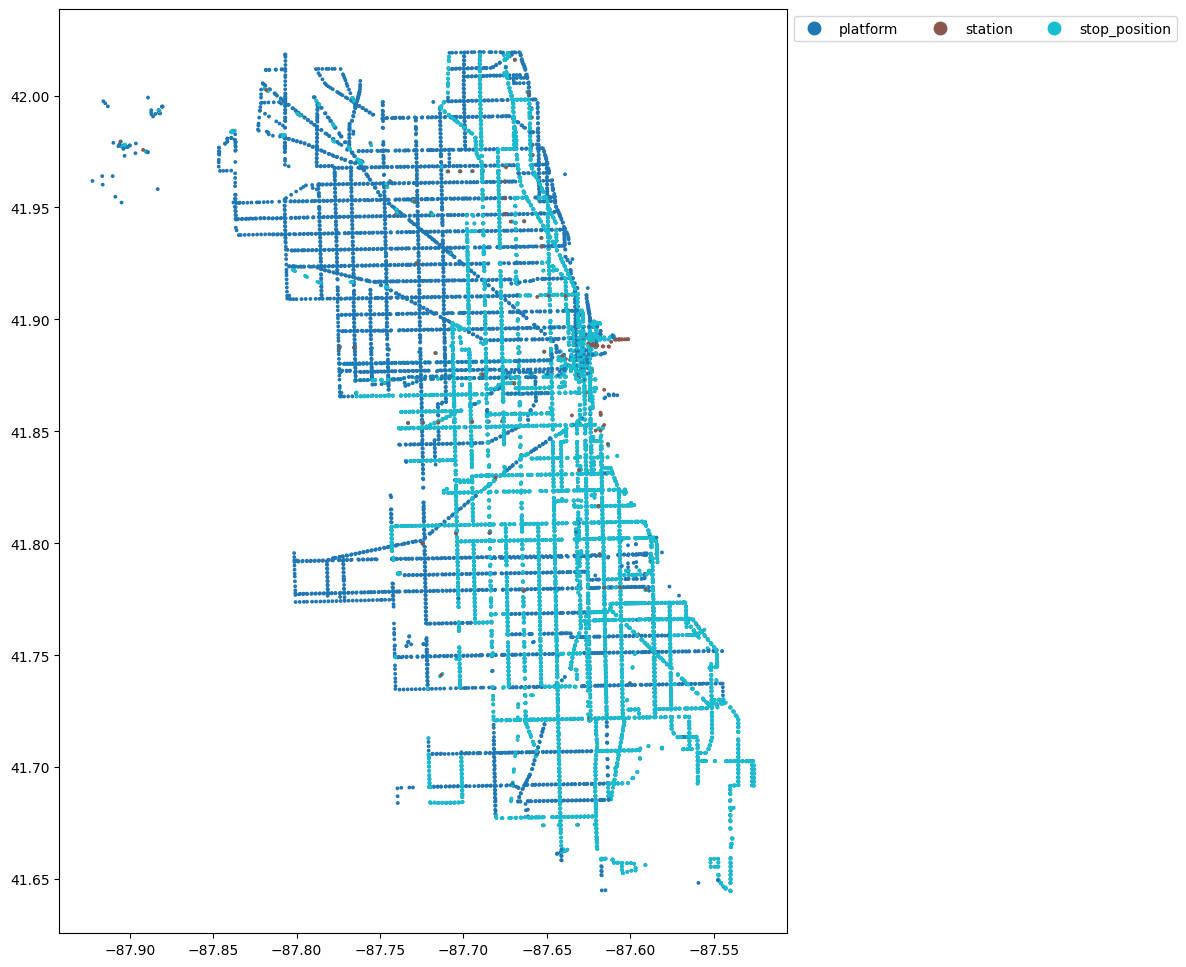

In [243]:
testDF2 = df[df["public_transport"].notna()]
ax = testDF2.plot(column='public_transport', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))